In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import ast
import calendar

In [2]:
df = pd.read_csv('data.csv', sep = '#')
df.head()

,Position,Track Name,Artist,Streams,Date,Genre
0,1,Starboy,The Weeknd,3135625,2017-01-01,"['canadian pop', 'canadian contemporary r&b', ..."
1,2,Closer,The Chainsmokers,3015525,2017-01-01,"['pop', 'pop dance', 'tropical house', 'edm', ..."
2,3,Let Me Love You,DJ Snake,2545384,2017-01-01,"['pop', 'electronic trap', 'dance pop', 'edm',..."
3,4,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,2356604,2017-01-01,"['pop', 'uk dance', 'dance pop', 'uk funky', '..."
4,5,One Dance,Drake,2259887,2017-01-01,"['toronto rap', 'canadian pop', 'canadian hip ..."


In [3]:
df.dropna(inplace=True) 

In [4]:
#Converting the string genres into a list type
df["Genre"] = df['Genre'].apply(lambda x: ast.literal_eval(x))

In [5]:
#Defining cleaning functions
def get_keyword_separator(s):
    if "featuring" in s.lower():
        return "featuring"
    elif "feat" in s.lower():
        return "feat"
    else:
        return "with"
    
def check_if_song_is_featured(song_name):
    keyword = get_keyword_separator(song_name)
    idx_if_exists = song_name.lower().find(keyword)
    if idx_if_exists != -1:
        feat = song_name[idx_if_exists + len(keyword) + 1:-1]
        sep = "&" if "&" in feat else ","
        return [x.strip() for x in feat.split(sep)]
    else:
        return "None"
    
def get_number_of_singers(feat):
    if isinstance(feat, list):
        return len(feat) + 1
    else:
        return 1
    
def get_song_name_only(song_name):
    sep = 'feat' if 'feat' in song_name.lower() else "with"
    idx = song_name.lower().find(sep)
    if idx != -1:
        return song_name[:idx-1].strip() # -1 to skip the ")"
    else:
        return song_name

In [6]:
df["Year"] = df["Date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").year)
df["Month"] = df["Date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").month)
df["DayOfWeek"] = df["Date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isoweekday())
df["Featuring"] = df["Track Name"].apply(lambda x: check_if_song_is_featured(x))
df['Number Of Singers'] = df['Featuring'].apply(lambda x: get_number_of_singers(x))
df['SongName'] = df['Track Name'].apply(lambda x: get_song_name_only(x))

In [7]:
#Printing Cleaned Dataframe
df.to_csv("cleanData_spotify.csv")

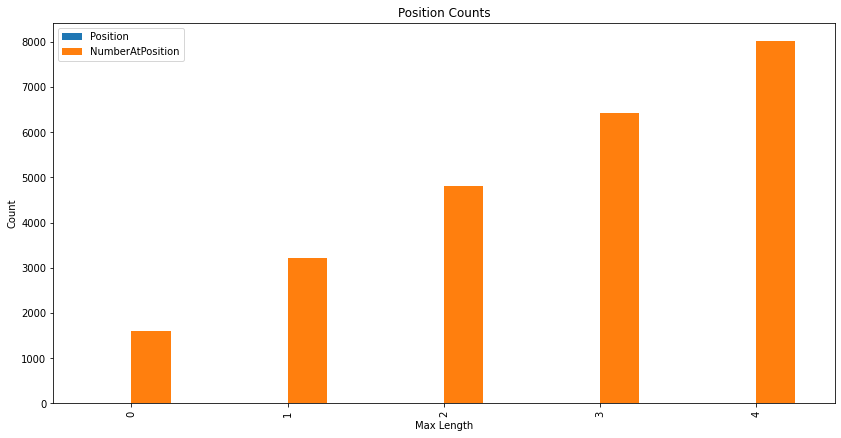

In [8]:
#Exploring some basic plots
plot_data = df\
.query("(Position <= 5)")\
.groupby(["Position"], as_index = False)\
.agg(NumberAtPosition = ("Position", "sum"))

plot_data.plot(kind='bar', title='Position Counts', figsize=(14,7), xlabel='Max Length', ylabel='Count')
plt.show()

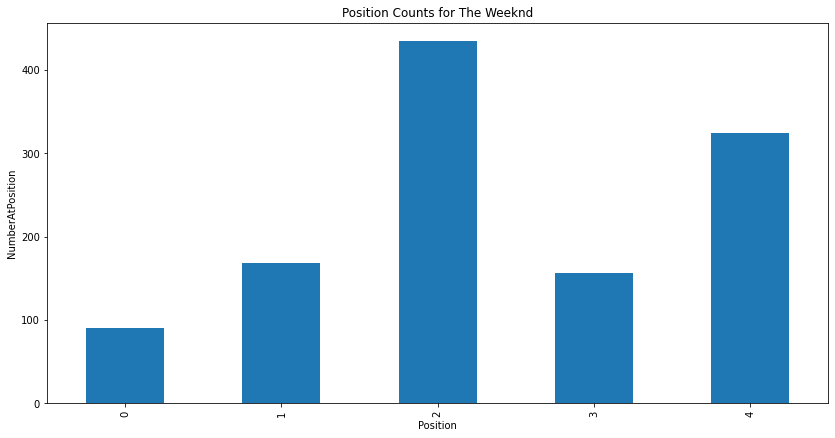

In [9]:
#Exploring the position in the dataset
position = 5
artist = 'The Weeknd'

plot_data = df\
.query("(Position <= @position) & (Artist == @artist)")\
.groupby(["Position"], as_index = False)\
.agg(NumberAtPosition = ("Position", "sum"))

plot_data
plot_data.NumberAtPosition.plot(kind='bar', title='Position Counts for The Weeknd', figsize=(14,7), xlabel='Position', ylabel='NumberAtPosition')
plt.show()

In [10]:
position = 5
artist = 'The Weeknd'

plot_data = df\
.query("(Position <= @position) & (Year == 2017) & (Month == 2)")\
.groupby(["Track Name"], as_index = False)\
.agg(NumberAtPosition = ("Position", "sum"))

In [11]:
#Table 2 complete
position = 5
artist = 'The Weeknd'

plot_data = df\
.query("(Artist == @artist)")\
.groupby(["Track Name"], as_index = False)\
.agg(TotalStreams = ("Streams", "sum"))\
.sort_values('TotalStreams', ascending=False)\
.drop_duplicates('Track Name').head(5)

In [12]:
#Table 1
plot_data = df\
.query("(Year == 2017) & (Month == 2)")\
.groupby(["Track Name"], as_index = False)\
.agg(TotalStreams = ("Streams", "sum"))\
.sort_values('TotalStreams', ascending=False)

In [13]:
#Table 3
#Testing queries
artist = 'The Weeknd'

top5Artists = df\
.groupby(["Artist"], as_index = False)\
.agg(TotalStreams = ("Streams", "sum"))\
.sort_values('TotalStreams', ascending=False).head(5)

top5Artists = top5Artists.Artist

TotalStreamsTop5 = df\
.query("(Artist.isin(@top5Artists))")\
.groupby(["Year","Artist", "Track Name"], as_index = False)\
.agg(TotalStreams = ("Streams", "sum"))

In [14]:
#testing plotly

import plotly.io as pio
import plotly.graph_objects as go
from plotly.figure_factory import create_distplot
import plotly.express as px
pio.templates["draft"] = go.layout.Template(
    layout_annotations=[
        dict(
            textangle=-30,
            opacity=0.1,
            font=dict(color="black", size=100),
            xref="paper",
            yref="paper",
            x=0.5,
            y=0.5,
            showarrow=False,
        )
    ]
)
pio.templates.default = "draft"

In [15]:
#importing plotly modules
import plotly
from plotly import version
print (version)
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

<module 'plotly.version' from '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/plotly/version.py'>


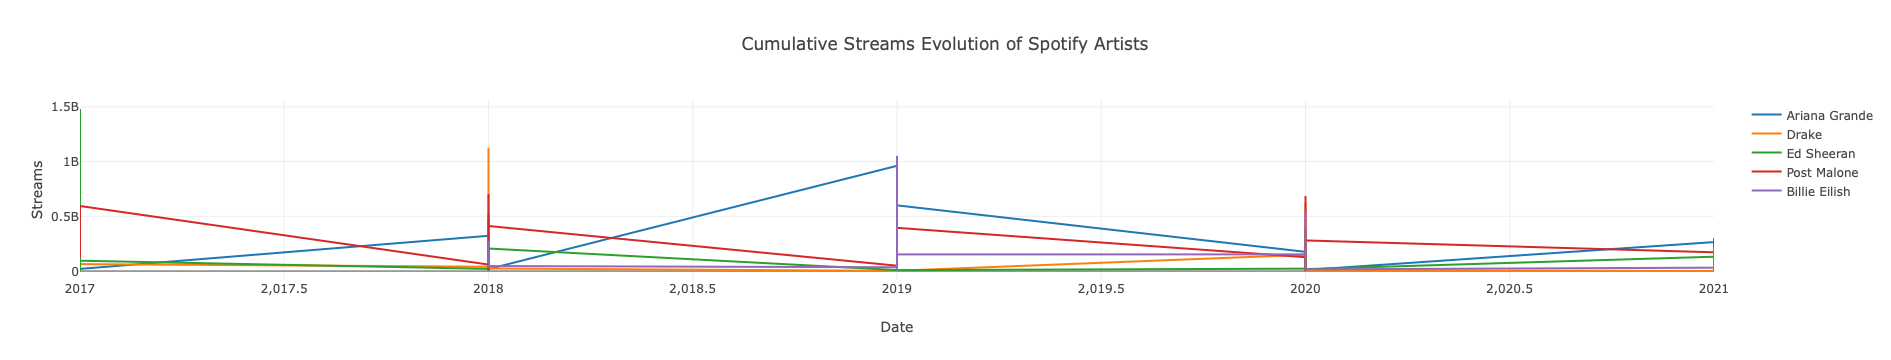

In [16]:
# Testing cumulative Streams evolution for 2 artists
%matplotlib inline

fig = go.Figure()
for artist in TotalStreamsTop5.Artist.unique():
    artist_data = TotalStreamsTop5.query("(Artist == @artist)")
    fig.add_trace(go.Scatter(x=artist_data['Year'], y=artist_data['TotalStreams'], name=artist))

fig.update_layout(xaxis_title="Date", yaxis_title="Streams", title="Cumulative Streams Evolution of Spotify Artists")
fig.show()

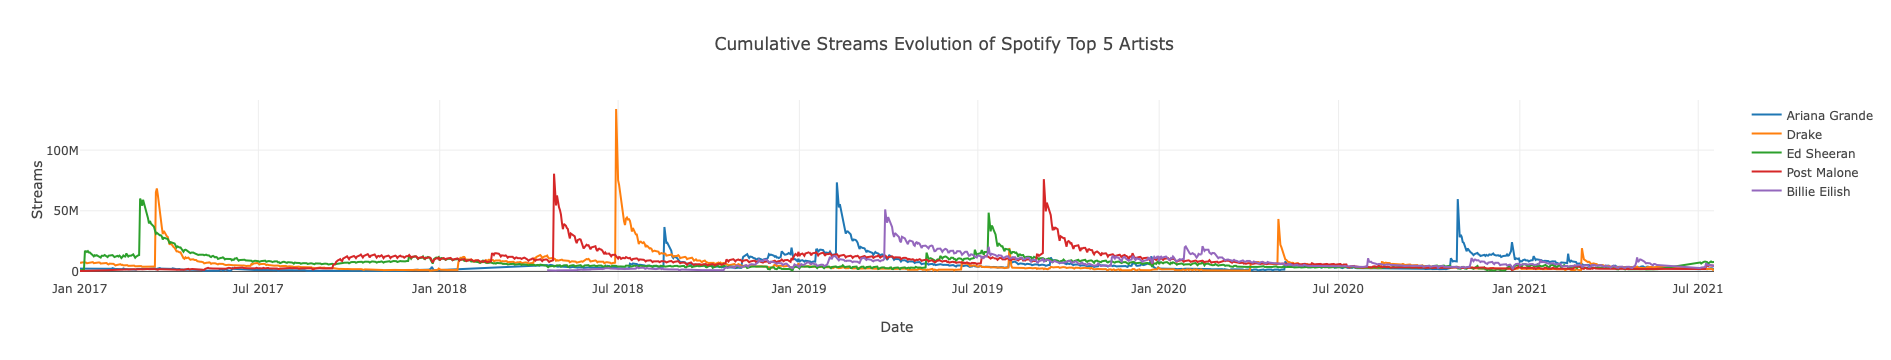

In [17]:
#Cumulative stream evolution for all dates
top5Artists = df\
.groupby(["Artist"], as_index = False)\
.agg(TotalStreams = ("Streams", "sum"))\
.sort_values('TotalStreams', ascending=False).head(5)

top5Artists = top5Artists.Artist

TotalStreamsTop5 = df\
.query("(Artist.isin(@top5Artists))")\
.groupby(["Date","Artist"], as_index = False)\
.agg(TotalStreams = ("Streams", "sum"))
fig = go.Figure()

for artist in TotalStreamsTop5.Artist.unique():
    artist_data = TotalStreamsTop5.query("(Artist == @artist)")
    fig.add_trace(go.Scatter(x=artist_data['Date'], y=artist_data['TotalStreams'], name=artist))

fig.update_layout(xaxis_title="Date", yaxis_title="Streams", title="Cumulative Streams Evolution of Spotify Top 5 Artists")

fig.show()

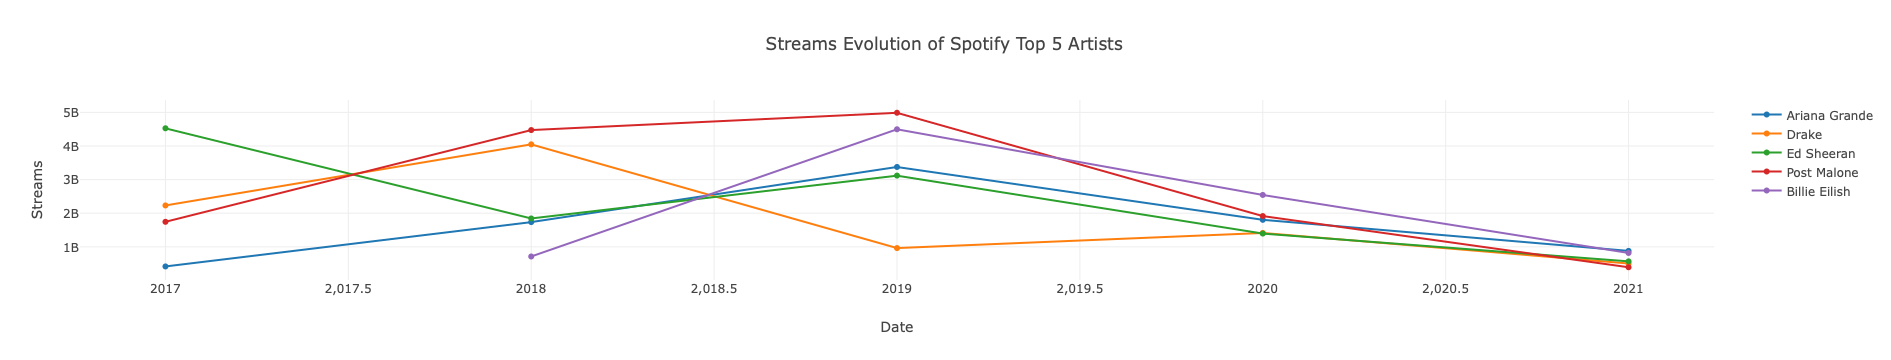

In [18]:
%matplotlib inline
#Table 3
#Testing the query and graph of our top 5  artists based on streams for each year cumulative
artist = 'The Weeknd'

top5Artists = df\
.groupby(["Artist"], as_index = False)\
.agg(TotalStreams = ("Streams", "sum"))\
.sort_values('TotalStreams', ascending=False).head(5)

top5Artists = top5Artists.Artist

TotalStreamsTop5 = df\
.query("(Artist.isin(@top5Artists))")\
.groupby(["Year","Artist"], as_index = False)\
.agg(TotalStreams = ("Streams", "sum"))



plot_data = df\
.query("(Artist == @artist)")\
.groupby(["Year"], as_index = False)\
.agg(TotalStreams = ("Streams", "sum"))\
.sort_values('TotalStreams', ascending=False)


fig = go.Figure()
 
for artist in TotalStreamsTop5.Artist.unique():
    artist_data = TotalStreamsTop5.query("(Artist == @artist)")
    fig.add_trace(go.Scatter(x=artist_data['Year'], y=artist_data['TotalStreams'], name=artist))

fig.update_layout(xaxis_title="Date", yaxis_title="Streams", title=" Streams Evolution of Spotify Top 5 Artists")

fig.show()

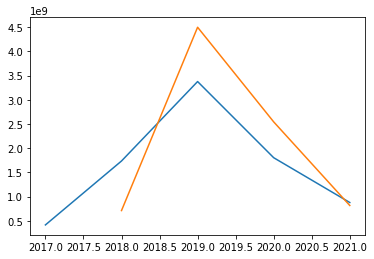

In [19]:
#Testing a simple comparator
artist = 'Ariana Grande'

TotalStreamsTop51 = TotalStreamsTop5[TotalStreamsTop5['Artist'] == artist]
TotalStreamsTop52 = TotalStreamsTop5[TotalStreamsTop5['Artist'] == 'Billie Eilish']

plt.plot(TotalStreamsTop51.Year,TotalStreamsTop51.TotalStreams)
plt.plot(TotalStreamsTop52.Year,TotalStreamsTop52.TotalStreams)
plt.show()
